In [1]:
#Packages
import warnings
warnings.filterwarnings('ignore')
import glob
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from PIL import Image
from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    FlattenTransformer
)


Bad key text.latex.preview in file C:\Users\mikep\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\mikep\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\mikep\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
tmp = [
    generate_multiphase(
        shape=(5, 100, 100),
        grain_size=grain_size,
        volume_fraction=volume_fraction,
        chunks=50,
        percent_variance=0.002
    )
    for (grain_size, volume_fraction) in zip(
        [(20, 7), (5, 30), (20, 20)],
        [(0.7, 0.3), (0.7, 0.3), (0.7, 0.3)]
    )
]

x_data = np.concatenate(tmp).persist()
x_data.shape

(15, 100, 100)

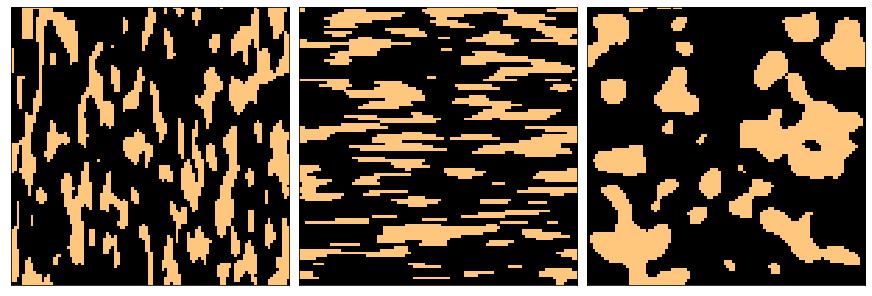

In [13]:
plot_microstructures(*x_data[::6], cmap='copper', colorbar=False);

In [14]:
data = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(x_data)
data.shape

(15, 100, 100, 2)

In [15]:
two_points = TwoPointCorrelation(
    periodic_boundary=True,
    cutoff=15,
    correlations=[(0, 0), (0, 1)]
).transform(data)
two_points.shape

(15, 31, 31, 2)

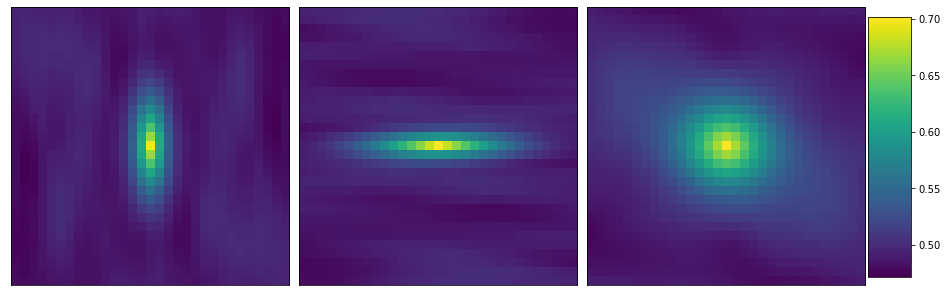

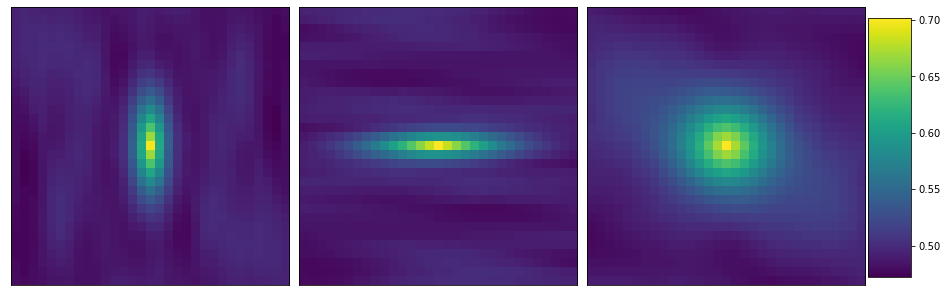

In [16]:
plot_microstructures(
    two_points[0, :, :, 0],
    two_points[6, :, :, 0],
    two_points[12, :, :, 0],
    showticks=False
)

In [17]:
reshaped_two_points=two_points.reshape(15, -1)
reshaped_two_points.shape

(15, 1922)

In [18]:
#Vertical pc scores.
pca = PCA(svd_solver='full', n_components=2, random_state=10)
pc_scores=pca.fit_transform(reshaped_two_points)
pc_scores.shape
print(pc_scores)

[[ 0.05256746  0.60168913]
 [ 0.01017327  0.58082374]
 [-0.11105594  0.48452006]
 [-0.11550745  0.56490616]
 [ 0.00657392  0.52855777]
 [ 0.63304694 -0.24901887]
 [ 0.55801264 -0.24389751]
 [ 0.62341882 -0.26876511]
 [ 0.7223464  -0.17114918]
 [ 0.57833102 -0.33969476]
 [-0.62557687 -0.31891057]
 [-0.46794072 -0.29521967]
 [-0.57534428 -0.43131206]
 [-0.6967362  -0.11020435]
 [-0.592309   -0.33232479]]


In [19]:
#Explained variance by each principal component.
exp_var_pca=pca.explained_variance_ratio_
print(exp_var_pca)

[0.49036419 0.30862943]


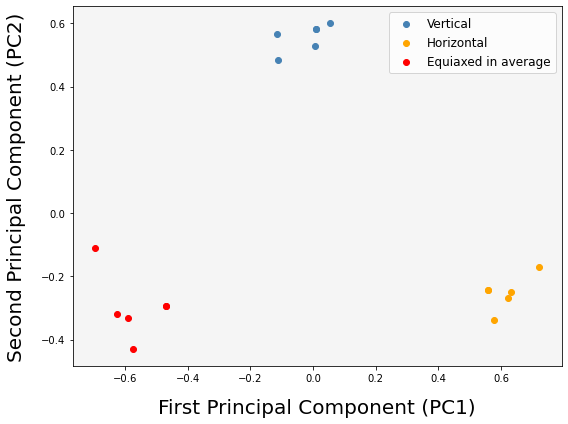

In [25]:
#Principal component analysis visualization.
small = 10
medium = 12
bigger = 18

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=medium)     # fontsize of the axes title
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=medium)    # legend fontsize
plt.rc('figure', titlesize=bigger)  # fontsize of the figure title

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i in range(0,5):
    plt.plot(pc_scores[i,0], pc_scores[i,1], c='steelblue', marker='o')
for j in range(5,10):
    plt.plot(pc_scores[j,0], pc_scores[j,1], c='orange', marker='o')
for k in range(10,15):
    plt.plot(pc_scores[k,0], pc_scores[k,1], c='r', marker='o')

plt.xlabel("First Principal Component (PC1)", fontsize=20, labelpad=15)
plt.ylabel("Second Principal Component (PC2)", fontsize=20, labelpad=15)
#plt.title("PCA Visualization", fontsize=20)

#plt.grid(color = 'black', linestyle = '--', linewidth = 0.4)
ax.set_facecolor('whitesmoke')

#plt.patch.set_edgecolor('black')  
#plt.patch.set_linewidth('1')  

plt.scatter(pc_scores[1,0], pc_scores[1,1], label="Vertical", c='steelblue', marker='o')
plt.scatter(pc_scores[6,0], pc_scores[6,1], label="Horizontal", c='orange', marker='o')
plt.scatter(pc_scores[11,0], pc_scores[11,1], label="Equiaxed in average", c='r', marker='o')

plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(r"C:\Users\mikep\Desktop\thesis\figures\two-point-figure.pdf")
plt.show()